In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, precision_recall_curve, auc

rates = 2**np.arange(7)/80
print(rates)

[0.0125 0.025  0.05   0.1    0.2    0.4    0.8   ]


In [2]:
def get_inputs(sm):
    seq_len = 220
    sm = sm.split()
    if len(sm)>218:
        print('SMILES is too long ({:d})'.format(len(sm)))
        sm = sm[:109]+sm[-109:]
    ids = [vocab.stoi.get(token, unk_index) for token in sm]
    ids = [sos_index] + ids + [eos_index]
    seg = [1]*len(ids)
    padding = [pad_index]*(seq_len - len(ids))
    ids.extend(padding), seg.extend(padding)
    return ids, seg

def get_array(smiles):
    x_id, x_seg = [], []
    for sm in smiles:
        a,b = get_inputs(sm)
        x_id.append(a)
        x_seg.append(b)
    return torch.tensor(x_id), torch.tensor(x_seg)

# Smiles Transformer, RNN pre-training model

In [3]:
import torch
from pretrain_trfm import TrfmSeq2seq
from pretrain_rnn import RNNSeq2Seq
# from bert import BERT
from build_vocab import WordVocab
from utils import split

pad_index = 0
unk_index = 1
eos_index = 2
sos_index = 3
mask_index = 4

vocab = WordVocab.load_vocab('pretrained_model/vocab.pkl')

print(len(vocab))
trfm = TrfmSeq2seq(len(vocab), 256, len(vocab), 4)
trfm.load_state_dict(torch.load('pretrained_model/trfm_pretrained.pkl'))
trfm.eval()
print('Total parameters of Smiles Transformer model:', sum(p.numel() for p in trfm.parameters()))

hidden_size = 256
embed_size = 256


model = RNNSeq2Seq(len(vocab), embed_size, hidden_size, 3)
rnn = RNNSeq2Seq(len(vocab), 256, 256, 3)
rnn.load_state_dict(torch.load('pretrained_model/rnn_pretrained.pkl'))
rnn.eval()
print('Total parameters of RNN model:', sum(p.numel() for p in rnn.parameters()))

c:\users\anhtt\workingspace\pycharm\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


45
Total parameters of Smiles Transformer model: 4245037
Total parameters of RNN model: 4713517


In [4]:
def evaluate_classification(X, y, rate, n_repeats, model='lr'):
    roc_aucs, prc_aucs = np.empty(n_repeats), np.empty(n_repeats)
    for i in range(n_repeats):
        if model=='lr':
            clf = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=5000)
        elif model=='rf':
            clf = RandomForestClassifier(n_estimators=10)
        elif model=='mlp':
            clf = MLPClassifier(max_iter=5000)
        else:
            raise ValueError('Model "{}" is invalid. Specify "ridge" or "rf".'.format(model))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-rate, stratify=y)
        clf.fit(X_train, y_train)
        y_score = clf.predict_proba(X_test)
        roc_aucs[i] = roc_auc_score(y_test, y_score[:,1])
        precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])
        prc_aucs[i] = auc(recall, precision)
    ret = {}
    ret['roc_auc mean'] = np.mean(roc_aucs)
    ret['roc_auc std'] = np.std(roc_aucs)
    ret['prc_auc mean'] = np.mean(prc_aucs)
    ret['prc_auc std'] = np.std(prc_aucs)
    
    return ret

# BBBP dataset - Blood-brain barrier penetration

In [5]:
df = pd.read_csv('dataset/bbbp.csv')
L = len(df)
print(df.shape)
df.head()
x_split = [split(sm) for sm in df['smiles'].values]
xid, xseg = get_array(x_split)

(2050, 4)
SMILES is too long (256)
SMILES is too long (239)
SMILES is too long (258)
SMILES is too long (380)
SMILES is too long (332)


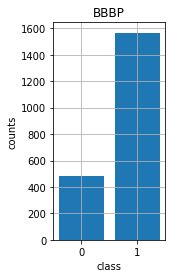

In [6]:
keys = ['0', '1']
bottom = df.groupby('p_np').count()['smiles'].values
plt.figure(figsize=(2,4))
plt.bar(keys, bottom)
plt.xlabel('class')
plt.ylabel('counts')
plt.title('BBBP')
plt.grid()
plt.show()

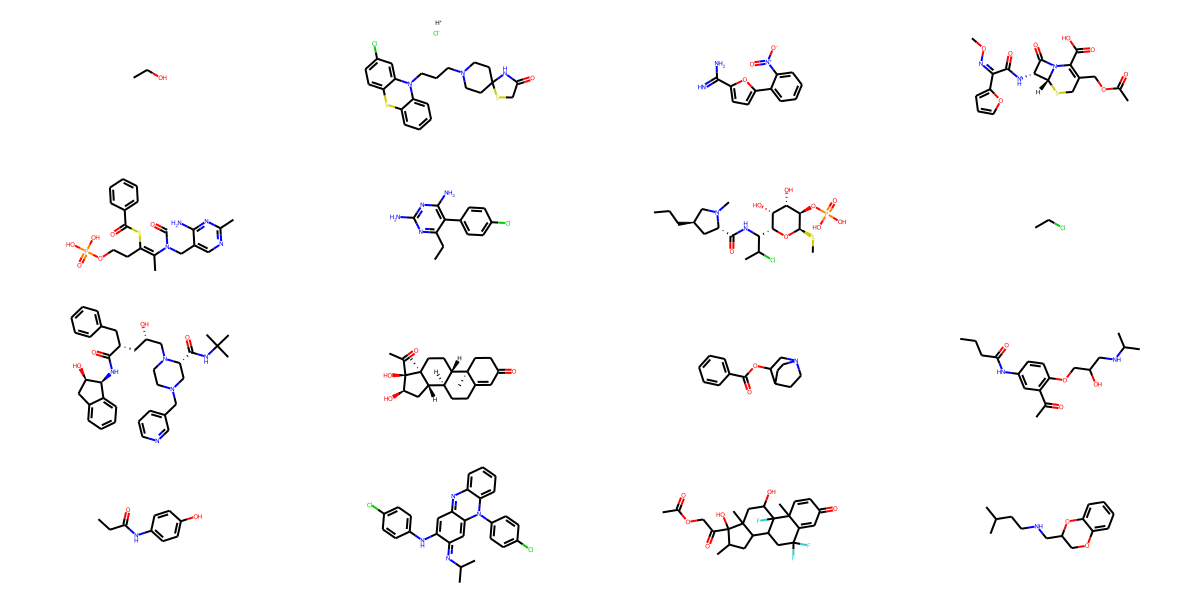

In [7]:
from rdkit.Chem import Draw, MolFromSmiles, MolToSmiles
rands = np.random.choice(L, 16, replace=False)
smiles = df.iloc[rands]['smiles'].values
mols = []
for s in smiles:
    if s is None:
        continue
    mol = MolFromSmiles(s)
    if mol is not None:
        mols.append(mol)
Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(300,150))

# Classification without Pre-training settings

Logistic Regression (LR)

In [8]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['p_np'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_LR = np.array(scores)
print("Average results: ", np.mean(scores_LR[:, 0]), np.mean(scores_LR[:, 1]))

0.0125 {'roc_auc mean': 0.625348965866554, 'roc_auc std': 0.048435619215120684, 'prc_auc mean': 0.8120102057494973, 'prc_auc std': 0.0254286469318849}
0.025 {'roc_auc mean': 0.5829678971998977, 'roc_auc std': 0.057989234547795976, 'prc_auc mean': 0.7859243629969476, 'prc_auc std': 0.03305267437589391}
0.05 {'roc_auc mean': 0.5842500413343457, 'roc_auc std': 0.05526483011078061, 'prc_auc mean': 0.7874674189844961, 'prc_auc std': 0.03181799597483344}
0.1 {'roc_auc mean': 0.582341485285726, 'roc_auc std': 0.031279193409619176, 'prc_auc mean': 0.7849238074580092, 'prc_auc std': 0.020983566011505958}
0.2 {'roc_auc mean': 0.6176118803249292, 'roc_auc std': 0.020219302669072563, 'prc_auc mean': 0.7962053581856071, 'prc_auc std': 0.013564571124256181}
0.4 {'roc_auc mean': 0.6722415627292737, 'roc_auc std': 0.022313020224976027, 'prc_auc mean': 0.8275800003686532, 'prc_auc std': 0.017361405804311666}
0.8 {'roc_auc mean': 0.7162939297124601, 'roc_auc std': 0.0299484572265474, 'prc_auc mean': 0.8

Random Forest Classifier (RF)

In [9]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['p_np'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_RF = np.array(scores)
print("Average results: ", np.mean(scores_RF[:, 0]), np.mean(scores_RF[:, 1]))

0.0125 {'roc_auc mean': 0.6779130033207115, 'roc_auc std': 0.04683577355165353, 'prc_auc mean': 0.8728183343269945, 'prc_auc std': 0.019874665971197893}
0.025 {'roc_auc mean': 0.696225690854926, 'roc_auc std': 0.0312793357585616, 'prc_auc mean': 0.8796243216210338, 'prc_auc std': 0.015720131855644436}
0.05 {'roc_auc mean': 0.7442232142465224, 'roc_auc std': 0.02323120535908093, 'prc_auc mean': 0.9006035815871059, 'prc_auc std': 0.010882484269792391}
0.1 {'roc_auc mean': 0.7831924268362274, 'roc_auc std': 0.013576185786227388, 'prc_auc mean': 0.9183983712444996, 'prc_auc std': 0.006919741136505812}
0.2 {'roc_auc mean': 0.8291267426101759, 'roc_auc std': 0.0197139551856982, 'prc_auc mean': 0.9356427155369115, 'prc_auc std': 0.009022999883662466}
0.4 {'roc_auc mean': 0.8662828319882612, 'roc_auc std': 0.01164513702871933, 'prc_auc mean': 0.9514043445783702, 'prc_auc std': 0.005231643354698566}
0.8 {'roc_auc mean': 0.9012516056783373, 'roc_auc std': 0.015787023877536725, 'prc_auc mean': 0.

Multi-layer Perceptron Classifier (MLP)

In [10]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(xid, df['p_np'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_MLP = np.array(scores)
print("Average results: ", np.mean(scores_MLP[:, 0]), np.mean(scores_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.5790250082611499, 'roc_auc std': 0.07262679195791413, 'prc_auc mean': 0.7834717828767803, 'prc_auc std': 0.03983584072380458}
0.025 {'roc_auc mean': 0.5915987900312357, 'roc_auc std': 0.04439625830409785, 'prc_auc mean': 0.7859899898163054, 'prc_auc std': 0.028600299085106706}
0.05 {'roc_auc mean': 0.6273683848586072, 'roc_auc std': 0.029401640034090928, 'prc_auc mean': 0.8076976835451417, 'prc_auc std': 0.021035578328680308}
0.1 {'roc_auc mean': 0.6582655906089508, 'roc_auc std': 0.024133911440928787, 'prc_auc mean': 0.8218672314238035, 'prc_auc std': 0.01621522838175442}
0.2 {'roc_auc mean': 0.7046477179760519, 'roc_auc std': 0.02045761901776133, 'prc_auc mean': 0.851357577953979, 'prc_auc std': 0.013371158791265278}
0.4 {'roc_auc mean': 0.7524501100513572, 'roc_auc std': 0.015628561629773205, 'prc_auc mean': 0.8804784728753002, 'prc_auc std': 0.011050048799861148}
0.8 {'roc_auc mean': 0.8176583445868054, 'roc_auc std': 0.027329698845171644, 'prc_auc mean': 

Classification evaluation

C:\Users\anhtt\AppData\Local\Temp\ipykernel_27700\149481803.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


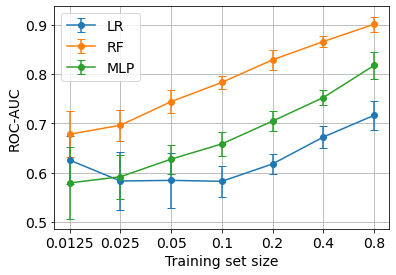

In [11]:
y_LR = np.transpose(scores_LR)[0, :]
err_LR = np.transpose(scores_LR)[1, :]

y_RF = np.transpose(scores_RF)[0, :]
err_RF = np.transpose(scores_RF)[1, :]

y_MLP = np.transpose(scores_MLP)[0, :]
err_MLP = np.transpose(scores_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_LR ,yerr=err_LR, fmt='-o', label='LR', capsize=4)
ax.errorbar(x, y_RF ,yerr=err_RF, fmt='-o', label='RF', capsize=4)
ax.errorbar(x, y_MLP ,yerr=err_MLP, fmt='-o', label='MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
fig.show()

# Pre-training SMILES TRANSFORMER model

In [12]:
X_sf = trfm.encode(torch.t(xid))
print(X_sf.shape)

There are 2050 molecules. It will take a little time.
(2050, 1024)


ST + Logistic Regression

In [13]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['p_np'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_LR = np.array(scores)
print("Average results: ", np.mean(scores_sf_LR[:, 0]), np.mean(scores_sf_LR[:, 1]))

0.0125 {'roc_auc mean': 0.8324468848693656, 'roc_auc std': 0.049290592476420036, 'prc_auc mean': 0.9379734730422609, 'prc_auc std': 0.022695044069781067}
0.025 {'roc_auc mean': 0.863270959082269, 'roc_auc std': 0.0237688271598905, 'prc_auc mean': 0.949442945123025, 'prc_auc std': 0.011427094029842733}
0.05 {'roc_auc mean': 0.8782246276616759, 'roc_auc std': 0.0201768870921116, 'prc_auc mean': 0.9551774554422566, 'prc_auc std': 0.011525159558862179}
0.1 {'roc_auc mean': 0.89940759761963, 'roc_auc std': 0.015820272494564563, 'prc_auc mean': 0.9635274541892194, 'prc_auc std': 0.008183091210638059}
0.2 {'roc_auc mean': 0.9140592590756211, 'roc_auc std': 0.00837640244918919, 'prc_auc mean': 0.9700663753133906, 'prc_auc std': 0.0035487784568257103}
0.4 {'roc_auc mean': 0.9289004035216435, 'roc_auc std': 0.006002878017469177, 'prc_auc mean': 0.9760066681896034, 'prc_auc std': 0.002805423642545999}
0.8 {'roc_auc mean': 0.9318566582128389, 'roc_auc std': 0.011511711312784867, 'prc_auc mean': 0.

ST + Random Forest Classifier

In [14]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['p_np'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_RF = np.array(scores)
print("Average results: ", np.mean(scores_sf_RF[:, 0]), np.mean(scores_sf_RF[:, 1]))

0.0125 {'roc_auc mean': 0.8235838899452329, 'roc_auc std': 0.03398488689269324, 'prc_auc mean': 0.9379230431913703, 'prc_auc std': 0.013833771414972761}
0.025 {'roc_auc mean': 0.8406066587187782, 'roc_auc std': 0.02418788577905396, 'prc_auc mean': 0.9447599423475266, 'prc_auc std': 0.009101893177886162}
0.05 {'roc_auc mean': 0.8730090745349702, 'roc_auc std': 0.014402161810151661, 'prc_auc mean': 0.9572629604710583, 'prc_auc std': 0.005785996525791598}
0.1 {'roc_auc mean': 0.8910074997962013, 'roc_auc std': 0.01239327662543776, 'prc_auc mean': 0.9632099204058676, 'prc_auc std': 0.005367419916565151}
0.2 {'roc_auc mean': 0.9067963862789334, 'roc_auc std': 0.008632303875521797, 'prc_auc mean': 0.9691099972081128, 'prc_auc std': 0.003638342722990133}
0.4 {'roc_auc mean': 0.9204422230374174, 'roc_auc std': 0.006307950029488096, 'prc_auc mean': 0.9736589832581778, 'prc_auc std': 0.002641075896416465}
0.8 {'roc_auc mean': 0.9258843582227201, 'roc_auc std': 0.015664176182167196, 'prc_auc mean

ST + Multi-layer Perceptron Classifier (MLP)

In [15]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_sf, df['p_np'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_sf_MLP = np.array(scores)
print("Average results: ", np.mean(scores_sf_MLP[:, 0]), np.mean(scores_sf_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.8454301621352227, 'roc_auc std': 0.034257080387385806, 'prc_auc mean': 0.9463932393430963, 'prc_auc std': 0.014343669724776055}
0.025 {'roc_auc mean': 0.8669035748824492, 'roc_auc std': 0.02862404534444423, 'prc_auc mean': 0.952878157975276, 'prc_auc std': 0.012266017925222448}
0.05 {'roc_auc mean': 0.8916534982025046, 'roc_auc std': 0.014208194706089918, 'prc_auc mean': 0.9612154654856218, 'prc_auc std': 0.0063260203122681375}
0.1 {'roc_auc mean': 0.9112574794163202, 'roc_auc std': 0.00781183254387794, 'prc_auc mean': 0.970632462871593, 'prc_auc std': 0.0033896570546784414}
0.2 {'roc_auc mean': 0.9256605804431002, 'roc_auc std': 0.007743627303063325, 'prc_auc mean': 0.975768939560826, 'prc_auc std': 0.002665584385059268}
0.4 {'roc_auc mean': 0.9350859317681586, 'roc_auc std': 0.006402334760511903, 'prc_auc mean': 0.9793121552403432, 'prc_auc std': 0.0022966945518260486}
0.8 {'roc_auc mean': 0.9410213761075064, 'roc_auc std': 0.01189264083817974, 'prc_auc mean

SMILES TRANSFORMER evaluation

C:\Users\anhtt\AppData\Local\Temp\ipykernel_27700\2341833957.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


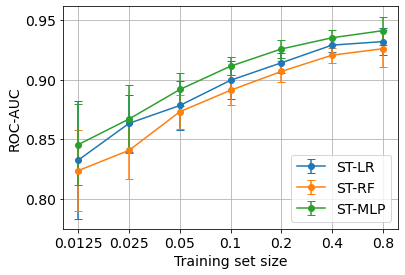

In [16]:
y_sf_LR = np.transpose(scores_sf_LR)[0, :]
err_sf_LR = np.transpose(scores_sf_LR)[1, :]

y_sf_RF = np.transpose(scores_sf_RF)[0, :]
err_sf_RF = np.transpose(scores_sf_RF)[1, :]

y_sf_MLP = np.transpose(scores_sf_MLP)[0, :]
err_sf_MLP = np.transpose(scores_sf_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_sf_LR ,yerr=err_sf_LR, fmt='-o', label='ST-LR', capsize=4)
ax.errorbar(x, y_sf_RF ,yerr=err_sf_RF, fmt='-o', label='ST-RF', capsize=4)
ax.errorbar(x, y_sf_MLP ,yerr=err_sf_MLP, fmt='-o', label='ST-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
plt.savefig('figures/BBBP_st_eval.png', dpi=300)
fig.show()

# Pre-training RNN model

In [17]:
X_rnn = rnn.encode(torch.t(xid))
print(X_rnn.shape)

There are 2050 molecules. It will take a little time.
(2050, 1024)


RNN + Logistic Regression

In [18]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['p_np'].values, rate, 20, model='lr')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_LR = np.array(scores)
print("Average results: ", np.mean(scores_rnn_LR[:, 0]), np.mean(scores_rnn_LR[:, 1]))

0.0125 {'roc_auc mean': 0.7781683541080938, 'roc_auc std': 0.0391762506504052, 'prc_auc mean': 0.8950782246272787, 'prc_auc std': 0.036982169318475144}
0.025 {'roc_auc mean': 0.8144170807349852, 'roc_auc std': 0.023632343538724086, 'prc_auc mean': 0.9216890060410623, 'prc_auc std': 0.021906257238013815}
0.05 {'roc_auc mean': 0.8467132245032929, 'roc_auc std': 0.024721660850366322, 'prc_auc mean': 0.9397118864687739, 'prc_auc std': 0.02334845916630392}
0.1 {'roc_auc mean': 0.881631124154235, 'roc_auc std': 0.015271382660245188, 'prc_auc mean': 0.9575516565848673, 'prc_auc std': 0.013046126830484103}
0.2 {'roc_auc mean': 0.9056508292634555, 'roc_auc std': 0.009382908635375598, 'prc_auc mean': 0.9678476594170531, 'prc_auc std': 0.004525280955581258}
0.4 {'roc_auc mean': 0.9292455979457079, 'roc_auc std': 0.0057721208090264564, 'prc_auc mean': 0.9766700204007529, 'prc_auc std': 0.003245687189463329}
0.8 {'roc_auc mean': 0.9355456012647805, 'roc_auc std': 0.01260641525492104, 'prc_auc mean'

RNN + Random Forest Classifier

In [19]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['p_np'].values, rate, 20, model='rf')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_RF = np.array(scores)
print("Average results: ", np.mean(scores_rnn_RF[:, 0]), np.mean(scores_rnn_RF[:, 1]))

0.0125 {'roc_auc mean': 0.7923760082665668, 'roc_auc std': 0.028407842586453225, 'prc_auc mean': 0.9249628925368218, 'prc_auc std': 0.013356098260538235}
0.025 {'roc_auc mean': 0.8309372255755271, 'roc_auc std': 0.029740303224880745, 'prc_auc mean': 0.9414106196893769, 'prc_auc std': 0.012094202010055849}
0.05 {'roc_auc mean': 0.8657967067134293, 'roc_auc std': 0.018980927566732107, 'prc_auc mean': 0.9542667433988907, 'prc_auc std': 0.007780251986808311}
0.1 {'roc_auc mean': 0.8957865003668382, 'roc_auc std': 0.012451361907700086, 'prc_auc mean': 0.9657492767140525, 'prc_auc std': 0.004961839780380568}
0.2 {'roc_auc mean': 0.9080361496062341, 'roc_auc std': 0.010390694102117714, 'prc_auc mean': 0.9699512090146053, 'prc_auc std': 0.004064138185641019}
0.4 {'roc_auc mean': 0.9250058694057227, 'roc_auc std': 0.006399501293956223, 'prc_auc mean': 0.9756416636284694, 'prc_auc std': 0.002519493129516961}
0.8 {'roc_auc mean': 0.9403568723032839, 'roc_auc std': 0.013323647449121389, 'prc_auc m

RNN + Multi-layer Perceptron Classifier (MLP)

In [20]:
scores = []
for rate in rates:
    score_dic = evaluate_classification(X_rnn, df['p_np'].values, rate, 20, model='mlp')
    print(rate, score_dic)
    scores.append([score_dic['roc_auc mean'], score_dic['roc_auc std']])
scores_rnn_MLP = np.array(scores)
print("Average results: ", np.mean(scores_rnn_MLP[:, 0]), np.mean(scores_rnn_MLP[:, 1]))

0.0125 {'roc_auc mean': 0.7796368073499857, 'roc_auc std': 0.04011240234952697, 'prc_auc mean': 0.9072079066339989, 'prc_auc std': 0.03453187605490178}
0.025 {'roc_auc mean': 0.7980819466213137, 'roc_auc std': 0.043233700452096374, 'prc_auc mean': 0.9101628805871813, 'prc_auc std': 0.0346998294672545}
0.05 {'roc_auc mean': 0.8358191735764524, 'roc_auc std': 0.025266321909046614, 'prc_auc mean': 0.9332376267843001, 'prc_auc std': 0.024897904588140556}
0.1 {'roc_auc mean': 0.8584481535827833, 'roc_auc std': 0.014856578640974291, 'prc_auc mean': 0.9538812247152688, 'prc_auc std': 0.011566377016925082}
0.2 {'roc_auc mean': 0.8855255410665148, 'roc_auc std': 0.009349165518270955, 'prc_auc mean': 0.9641110560274248, 'prc_auc std': 0.005427200957416314}
0.4 {'roc_auc mean': 0.9127878760088042, 'roc_auc std': 0.00832922547342661, 'prc_auc mean': 0.9732002071846695, 'prc_auc std': 0.0028559813750054417}
0.8 {'roc_auc mean': 0.9390385692170877, 'roc_auc std': 0.008197621350785028, 'prc_auc mean'

# Pre-training RNN Evaluation

C:\Users\anhtt\AppData\Local\Temp\ipykernel_27700\1491995531.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


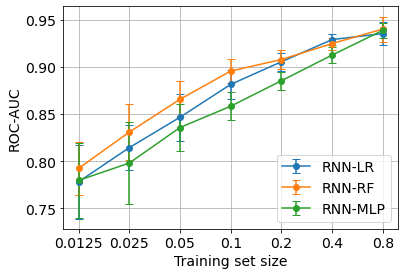

In [21]:
y_rnn_LR = np.transpose(scores_rnn_LR)[0, :]
err_rnn_LR = np.transpose(scores_rnn_LR)[1, :]

y_rnn_RF = np.transpose(scores_rnn_RF)[0, :]
err_rnn_RF = np.transpose(scores_rnn_RF)[1, :]

y_rnn_MLP = np.transpose(scores_rnn_MLP)[0, :]
err_rnn_MLP = np.transpose(scores_rnn_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_rnn_LR ,yerr=err_rnn_LR, fmt='-o', label='RNN-LR', capsize=4)
ax.errorbar(x, y_rnn_RF ,yerr=err_rnn_RF, fmt='-o', label='RNN-RF', capsize=4)
ax.errorbar(x, y_rnn_MLP ,yerr=err_rnn_MLP, fmt='-o', label='RNN-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
fig.show()

# Classification evaluation with Pre-training Smiles Transformer, RNN and without pre-training

C:\Users\anhtt\AppData\Local\Temp\ipykernel_27700\1838705112.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


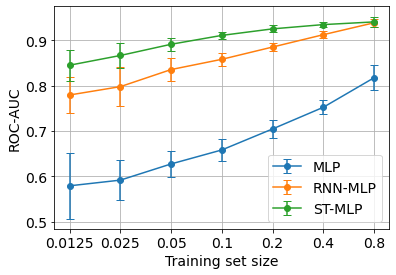

In [22]:
y_MLP = np.transpose(scores_MLP)[0, :]
err_MLP = np.transpose(scores_MLP)[1, :]

y_rnn_MLP = np.transpose(scores_rnn_MLP)[0, :]
err_rnn_MLP = np.transpose(scores_rnn_MLP)[1, :]

y_sf_MLP = np.transpose(scores_sf_MLP)[0, :]
err_sf_MLP = np.transpose(scores_sf_MLP)[1, :]

fig = plt.figure(figsize=(6,9))
plt.rcParams['font.size'] = 14
x=['0.0125','0.025', '0.05',   '0.1',    '0.2',    '0.4',    '0.8']
ax = fig.add_subplot(2, 1, 1)

ax.errorbar(x, y_MLP ,yerr=err_MLP, fmt='-o', label='MLP', capsize=4)
ax.errorbar(x, y_rnn_MLP ,yerr=err_rnn_MLP, fmt='-o', label='RNN-MLP', capsize=4)
ax.errorbar(x, y_sf_MLP ,yerr=err_sf_MLP, fmt='-o', label='ST-MLP', capsize=4)

ax.set_xticks(x)
ax.set_xlabel('Training set size')
ax.set_ylabel('ROC-AUC')
ax.legend()
ax.grid()
plt.savefig('figures/BBBP_pretrain_eval.png', dpi=300)
fig.show()

# Visualization of the Latent Space

In [23]:
from sklearn.manifold import TSNE
X_reduced = TSNE(n_components=2, random_state=0).fit_transform(X_sf)

c:\users\anhtt\workingspace\pycharm\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\anhtt\workingspace\pycharm\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [24]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(metric='euclidean').fit(X_reduced)
xs = np.linspace(-45, 60, 12)
ys = np.linspace(-40, 10, 12)
ids = []
pts = []
for x,y in zip(xs, ys):
    _, result = nn.kneighbors([[x, y]], n_neighbors=1)
    ids.append(result[0, 0])
    pts.append(X_reduced[result[0, 0]])
pts = np.array(pts)

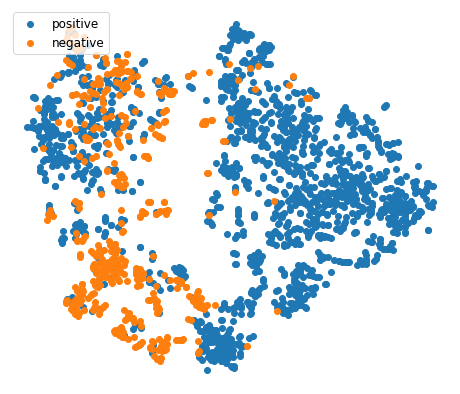

In [25]:
fig = plt.figure(figsize=(8,7))
plt.rcParams['font.size'] = 14
plt.rcParams['font.size'] = 12
plt.scatter(X_reduced[df['p_np']==1][:,0], X_reduced[df['p_np']==1][:,1], label='positive', marker='o')
plt.scatter(X_reduced[df['p_np']==0][:,0], X_reduced[df['p_np']==0][:,1], label='negative', marker='o')
plt.axis('off')
# for i in range(12):
#     plt.scatter(pts[i,0], pts[i,1], c='r', marker='${}$'.format(i), s=200*(1+i//10))
plt.legend(loc='upper left')
plt.savefig('figures/bbbp.png', dpi=300)
plt.show()